In [1]:
# !pip install matplotlib scikit-image
!pip install keras-tuner

import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from skimage.io import imread
from skimage.color import rgb2gray
from skimage import exposure
from skimage import color
from skimage.feature import SIFT
from skimage.filters import threshold_otsu
from skimage.filters import threshold_local
from skimage.morphology import binary_erosion
from skimage.measure import regionprops, find_contours

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV



import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the image paths and labels from the DataFrame
df = pd.read_csv('Dataset/cards.csv')

# For column names that contain space, replace the space with an underscore
df.columns = [c.replace(' ', '_') for c in df.columns]

# Add suits column
df['suit'] = df['labels'].str.split().str[-1]

# Remove rows with jokers
df = df[~df['suit'].str.contains('joker', case=False)]

# Remove unwanted columns
df = df.drop(columns = ['data_set'])
df = df.drop(columns = ['class_index'])
df = df.drop(columns = ['labels'])
df = df.drop(columns = ['card_type'])

# Add folder name to the filepath
df['filepaths'] = df['filepaths'].apply(lambda x: 'DatasetPreProcessed/' + x)
df.head()

,filepaths,suit
0,DatasetPreProcessed/train/ace of clubs/001.jpg,clubs
1,DatasetPreProcessed/train/ace of clubs/002.jpg,clubs
2,DatasetPreProcessed/train/ace of clubs/003.jpg,clubs
3,DatasetPreProcessed/train/ace of clubs/004.jpg,clubs
4,DatasetPreProcessed/train/ace of clubs/005.jpg,clubs


In [3]:
# Split dataframe into train and test sets, stratified by the 'suit' column
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['suit'], random_state=42)

# Split train set into train and validation sets, stratified by the 'suit' column
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['suit'], random_state=42)

# Check class distribution in the train, validation, and test sets
train_class_distribution = train_df['suit'].value_counts(normalize=True)
val_class_distribution = val_df['suit'].value_counts(normalize=True)
test_class_distribution = test_df['suit'].value_counts(normalize=True)

print("Train Set - Class Distribution:")
print(train_class_distribution)

print("Validation Set - Class Distribution:")
print(val_class_distribution)

print("Test Set - Class Distribution:")
print(test_class_distribution)

Train Set - Class Distribution:
spades      0.269171
hearts      0.246010
diamonds    0.243675
clubs       0.241144
Name: suit, dtype: float64
Validation Set - Class Distribution:
spades      0.269261
hearts      0.245914
diamonds    0.243580
clubs       0.241245
Name: suit, dtype: float64
Test Set - Class Distribution:
spades      0.268991
hearts      0.245953
diamonds    0.244085
clubs       0.240971
Name: suit, dtype: float64


## Augment Images

In [4]:
# Initialize data generator class

train_data_generator = ImageDataGenerator(
    rescale = 1/255.0,
    rotation_range= 45,
    zoom_range= 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    vertical_flip=True
)

test_data_generator = ImageDataGenerator(rescale = 1/255.0)

# Create data generators for train, validation, and test
batch_size = 32

train_generator = train_data_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)

valid_generator = train_data_generator.flow_from_dataframe(
    dataframe = val_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical'
)


test_generator = test_data_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'filepaths',
    y_col = 'suit',
    target_size = (224,224),
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False,
)


Found 5138 validated image filenames belonging to 4 classes.
Found 1285 validated image filenames belonging to 4 classes.
Found 1606 validated image filenames belonging to 4 classes.


In [5]:
# Load and preprocess the images
def load_and_preprocess_image(filepath):
    image = cv2.imread(filepath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    return image

# Convert to image to grayscale
def convert_to_grayscale(images):
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])
    gray_images = gray_images.astype(np.uint8)
    return gray_images

In [6]:
# Extract Keypoint Features and Descriptors
def detect_and_extract_keypoints(images):
    # Initialise SIFT 
    detector_and_extractor = SIFT(upsampling=2, 
                              n_octaves=10, 
                              n_scales=10, 
                              sigma_min=1.2, 
                              sigma_in=0.5, 
                              c_dog=0.01, 
                              c_edge=20, 
                              n_bins=36, 
                              lambda_ori=1.5, 
                              c_max=0.8, 
                              lambda_descr=6, 
                              n_hist=4, 
                              n_ori=8
                             )

    keypoint_descriptors = []
    keypoint_features = []
    keypoint_pixels = []

    for image in images:
        # Detect and extract keypoint features and descriptors
        detector_and_extractor.detect_and_extract(image)
        key_features = detector_and_extractor.keypoints
        key_descriptors = detector_and_extractor.descriptors

        if len(key_features) > 0:
            key_pixels = []

            for point in key_features:
                key_pixel = image[point[0], point[1]]
                key_pixel = key_pixel/255
                key_pixels.append(key_pixel)
        
            keypoint_pixels.append(key_pixels)
            keypoint_descriptors.append(key_descriptors)
            keypoint_features.append(key_features)

    # Setting the minimum number of features detected in an image
    min_feature_vec_len = 100

    # Slicing all the features, descriptors and pixels to the same length
    sliced_keypoint_feactures = np.array([feat_vec[:min_feature_vec_len] for feat_vec in keypoint_features])
    sliced_keypoint_descriptor = np.array([feat_vec[:min_feature_vec_len] for feat_vec in keypoint_descriptors])
    sliced_keypoint_pixels = np.array([feat_vec[:min_feature_vec_len] for feat_vec in keypoint_pixels])
    return sliced_keypoint_feactures, sliced_keypoint_descriptor, sliced_keypoint_pixels

# Flatten the feature vectors
def flatten_images(image_dataset):
    flattened_images = []

    for image in image_dataset:
        image = image/255
        flat_image = np.ravel(image)
        flattened_images.append(flat_image)
        
    return np.array(flattened_images)



In [7]:
# Load data from the generators
train_images = np.array([load_and_preprocess_image(train_generator.filepaths[i]) for i in range(len(train_generator.filenames))])
valid_images = np.array([load_and_preprocess_image(valid_generator.filepaths[j]) for j in range(len(valid_generator.filenames))])
test_images = np.array([load_and_preprocess_image(test_generator.filepaths[k]) for k in range(len(test_generator.filenames))])

# Convert to grayscale
train_gray_images = convert_to_grayscale(train_images)
valid_gray_images = convert_to_grayscale(valid_images)
test_gray_images = convert_to_grayscale(test_images)

# Extract Keypoint Feature Pixels
train_keypoint_pixels = detect_and_extract_keypoints(train_gray_images)
valid_keypoint_pixels = detect_and_extract_keypoints(valid_gray_images)
test_keypoint_pixels = detect_and_extract_keypoints(test_gray_images)

# Flatten the descriptor files
train_flat_descriptors = flatten_images(train_keypoint_pixels[1])
val_flat_descriptors = flatten_images(valid_keypoint_pixels[1])
test_flat_descriptors = flatten_images(test_keypoint_pixels[1])

# Create the Feature vector
flattened_train_images = np.hstack((train_flat_descriptors, train_keypoint_pixels[2]))
flattened_validation_images = np.hstack((val_flat_descriptors, valid_keypoint_pixels[2]))
flattened_test_images = np.hstack((test_flat_descriptors, test_keypoint_pixels[2]))

# Convert labels to arrays and one-hot encode
train_labels = to_categorical(train_generator.labels, num_classes=4)
valid_labels = to_categorical(valid_generator.labels, num_classes=4)
test_labels = to_categorical(test_generator.labels, num_classes=4)


In [17]:
# Convert labels to arrays and one-hot encode
train_labels = to_categorical(train_generator.labels, num_classes=4)
valid_labels = to_categorical(valid_generator.labels, num_classes=4)
test_labels = to_categorical(test_generator.labels, num_classes=4)

In [18]:
# SVM using the train Keypoint features
num_classes = 4

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(flattened_train_images.shape[1],)))
model.add(Dropout(0.03))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.03))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Train the CNN model
history = model.fit(flattened_train_images, train_labels,
                    batch_size=32,
                    epochs=7,
                    validation_data=(flattened_validation_images, valid_labels))


Epoch 1/7
  1/161 [..............................] - ETA: 51s - loss: 1.4800 - accuracy: 0.2500

2023-08-02 16:52:58.335468: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 1.5849 - accuracy: 0.2604

2023-08-02 16:53:00.589538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - 3s 16ms/step - loss: 1.5849 - accuracy: 0.2604 - val_loss: 1.3788 - val_accuracy: 0.2911
Epoch 2/7
161/161 [==============================] - 2s 13ms/step - loss: 1.4278 - accuracy: 0.3192 - val_loss: 1.3702 - val_accuracy: 0.3432
Epoch 3/7
161/161 [==============================] - 2s 13ms/step - loss: 1.3459 - accuracy: 0.3647 - val_loss: 1.3282 - val_accuracy: 0.3549
Epoch 4/7
161/161 [==============================] - 2s 13ms/step - loss: 1.3018 - accuracy: 0.3799 - val_loss: 1.3190 - val_accuracy: 0.3720
Epoch 5/7
161/161 [==============================] - 2s 13ms/step - loss: 1.2888 - accuracy: 0.4060 - val_loss: 1.3174 - val_accuracy: 0.3759
Epoch 6/7
161/161 [==============================] - 2s 13ms/step - loss: 1.2904 - accuracy: 0.4286 - val_loss: 1.2815 - val_accuracy: 0.4062
Epoch 7/7
161/161 [==============================] - 2s 13ms/step - loss: 1.2647 - accuracy: 0.4607 - val_loss: 1.2974 - val_accuracy: 0.3953


In [20]:
# Make predictions on the validation set
valid_predictions_probs = model.predict(flattened_validation_images)
valid_predictions = np.argmax(valid_predictions_probs, axis=1)

# Calculate validation accuracy
valid_accuracy = accuracy_score(valid_generator.labels, valid_predictions)
print("Validation Accuracy:", valid_accuracy)

# Make predictions on the test set
test_predictions_probs = model.predict(flattened_test_images)
test_predictions = np.argmax(test_predictions_probs, axis=1)

# Calculate test accuracy
test_accuracy = accuracy_score(test_generator.labels, test_predictions)
print("Test Accuracy:", test_accuracy)

41/41 [==============================] - 0s 3ms/step


2023-08-02 16:53:23.756718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Validation Accuracy: 0.3953307392996109
51/51 [==============================] - 0s 3ms/step
Test Accuracy: 0.3823163138231631


In [21]:
# Get the class names from the generator (assuming it has the 'class_indices' attribute)
class_names = list(test_generator.class_indices.keys())

# Calculate classification report for validation set
valid_report = classification_report(valid_generator.labels, valid_predictions, target_names=class_names)
print("Validation Classification Report:\n", valid_report)

# Calculate classification report for test set
test_report = classification_report(test_generator.labels, test_predictions, target_names=class_names)
print("Test Classification Report:\n", test_report)

Validation Classification Report:
               precision    recall  f1-score   support

       clubs       0.58      0.28      0.38       310
    diamonds       0.34      0.73      0.46       313
      hearts       0.41      0.30      0.35       316
      spades       0.44      0.27      0.34       346

    accuracy                           0.40      1285
   macro avg       0.44      0.40      0.38      1285
weighted avg       0.44      0.40      0.38      1285

Test Classification Report:
               precision    recall  f1-score   support

       clubs       0.50      0.26      0.35       387
    diamonds       0.33      0.70      0.45       392
      hearts       0.44      0.32      0.37       395
      spades       0.37      0.25      0.30       432

    accuracy                           0.38      1606
   macro avg       0.41      0.39      0.37      1606
weighted avg       0.41      0.38      0.37      1606



In [22]:
train_labels = np.array(train_generator.labels)
valid_labels = np.array(valid_generator.labels)
test_labels = np.array(test_generator.labels)

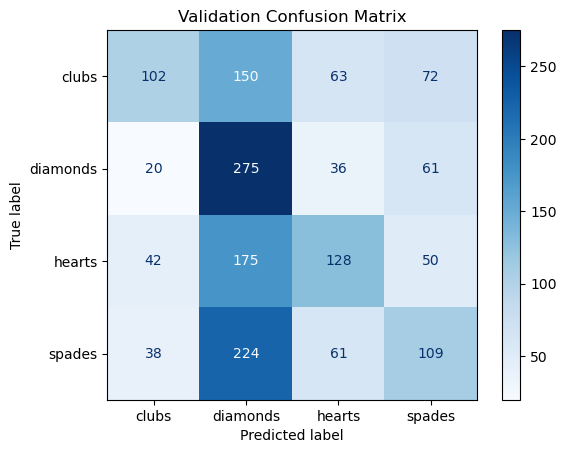

In [23]:
# Generating the confusion matrix for test dataset
test_confusion_matrix = confusion_matrix(test_labels, test_predictions)

# Displaying the confustion matrix
test_display_matrix = ConfusionMatrixDisplay(confusion_matrix = test_confusion_matrix,
                                             display_labels = class_names)

# Display Confusion Matrix
test_display_matrix.plot(cmap=plt.cm.Blues)
test_display_matrix.ax_.set_title('Validation Confusion Matrix')
plt.show()

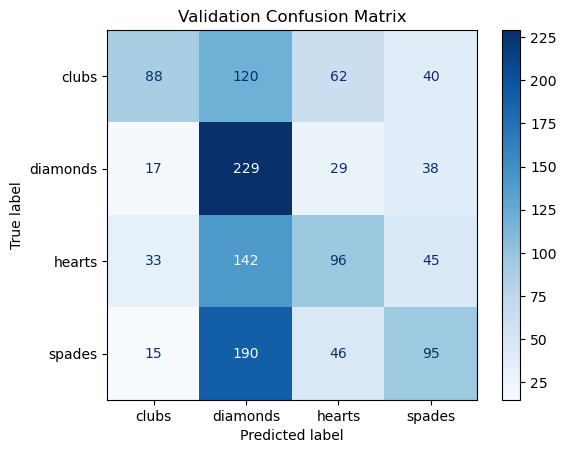

In [24]:
# Generating the confusion matrix validation dataset
val_confusion_matrix = confusion_matrix(valid_labels, valid_predictions)

# Displaying the confustion matrix
val_display_matrix = ConfusionMatrixDisplay(confusion_matrix = val_confusion_matrix,
                                            display_labels = class_names)

# Display Confusion Matrix
val_display_matrix.plot(cmap=plt.cm.Blues)
val_display_matrix.ax_.set_title('Validation Confusion Matrix')
plt.show()